## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 840.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.0 MB/s eta 0:00:00


In [30]:
# Importing library for data manipulation
import pandas as pd
import numpy as np

# to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# Importing the json module
import json

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to split the data
from sklearn.model_selection import train_test_split

# to compute metrics to evaluate the model
from sklearn import metrics

# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To tune different models
from sklearn.model_selection import GridSearchCV

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the dataset**

In [3]:
stock_news = pd.read_csv("/content/stock_news.csv")

In [4]:
# creating a copy of the dataset
data = stock_news.copy()

## **Data Overview**

Summary

- 99 Negative and 80 Positive and 170 Neutral feedbacks out of 349
- More Neutral feedbacks

In [ ]:
data.shape

(349, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [ ]:
data.describe()

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


In [ ]:
data['Label'].value_counts()

,count
Label,
0,170
-1,99
1,80


In [ ]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
data.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influenc...",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks u...",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,This article reports that the S&P 500 reached...,50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,The Federal Reserve is anticipated to keep in...,50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung E...",50.764999,50.849998,49.7775,48.70879,186139600,0


In [ ]:
data['News'].iloc[1]

" Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10"

In [ ]:
data['News'].iloc[239]

" The S&P 500 experienced a minor decline, with the Nasdaq Composite suffering greater losses due to a fall in tech stocks, led by Facebook. The Dow Jones Industrial Average saw minimal gains. The NYT reported that federal prosecutors were investigating data deals made by Facebook. Tech sector losses were offset by Apple's"

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<ipython-input-19-a2f5f6bbb666>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


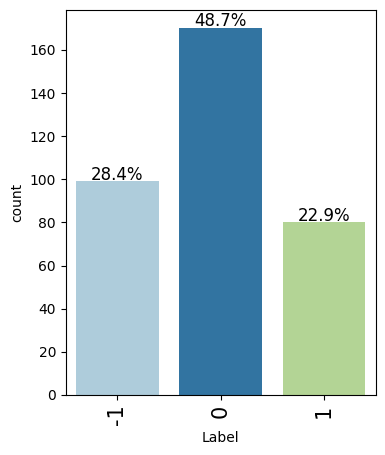

In [ ]:
labeled_barplot(data, "Label", perc=True)

In [ ]:
labeled_barplot(data, "Label", perc=True)

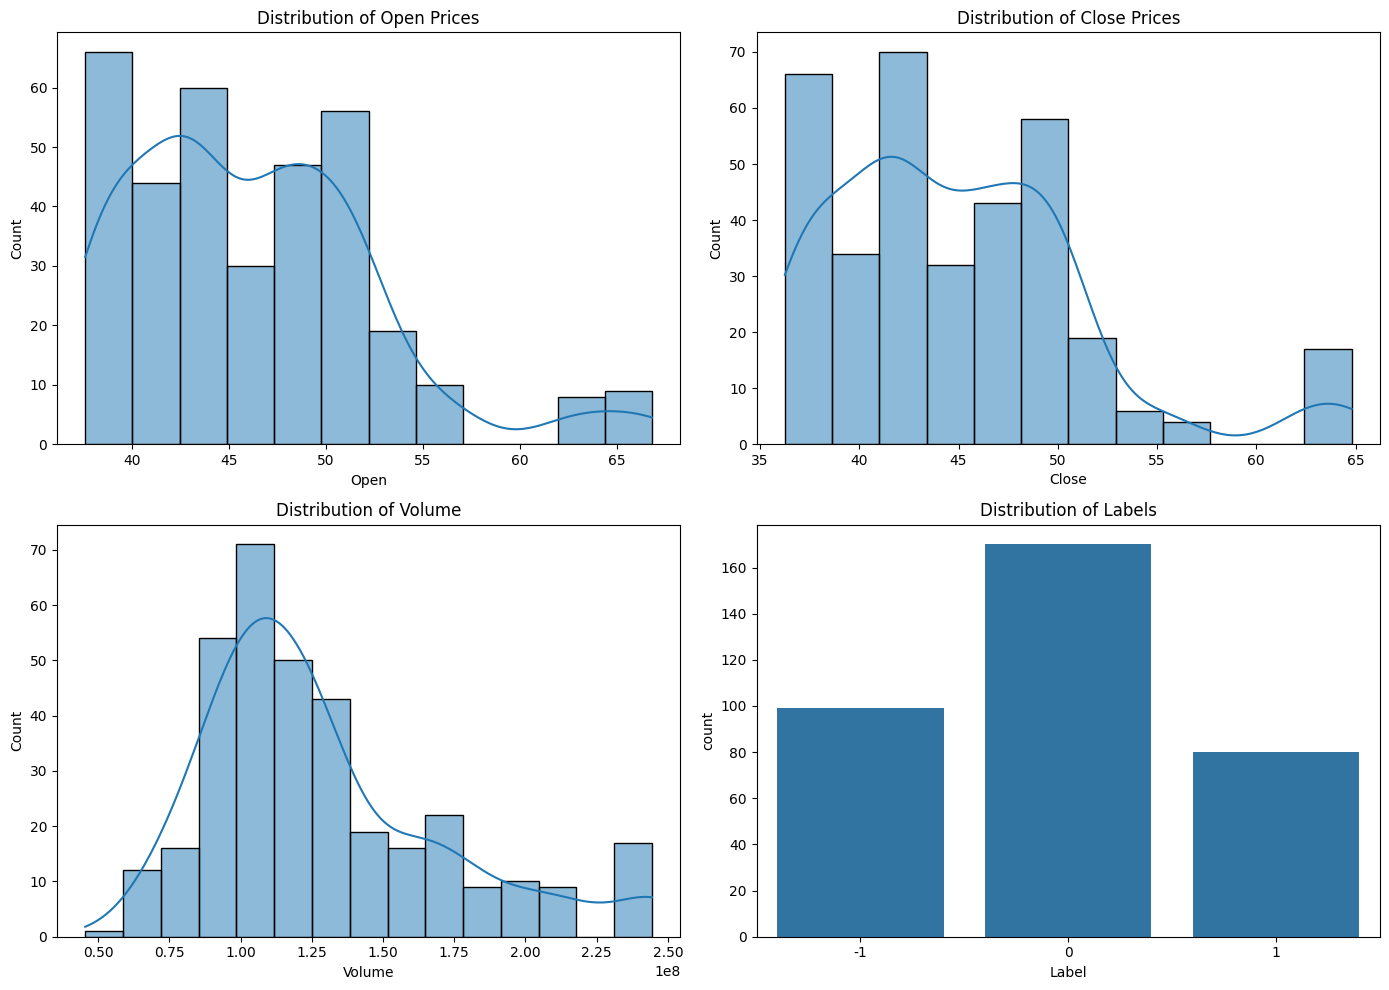

In [6]:
# Set up a figure for univariate analysis
plt.figure(figsize=(14, 10))

# Histogram for 'Open' prices
plt.subplot(2, 2, 1)
sns.histplot(data=data, x='Open', kde=True)
plt.title('Distribution of Open Prices')

# Histogram for 'Close' prices
plt.subplot(2, 2, 2)
sns.histplot(data=data, x='Close', kde=True)
plt.title('Distribution of Close Prices')

# Histogram for 'Volume'
plt.subplot(2, 2, 3)
sns.histplot(data=data, x='Volume', kde=True)
plt.title('Distribution of Volume')

# Count plot for 'Label'
plt.subplot(2, 2, 4)
sns.countplot(data=data, x='Label')
plt.title('Distribution of Labels')

plt.tight_layout()
plt.show()


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

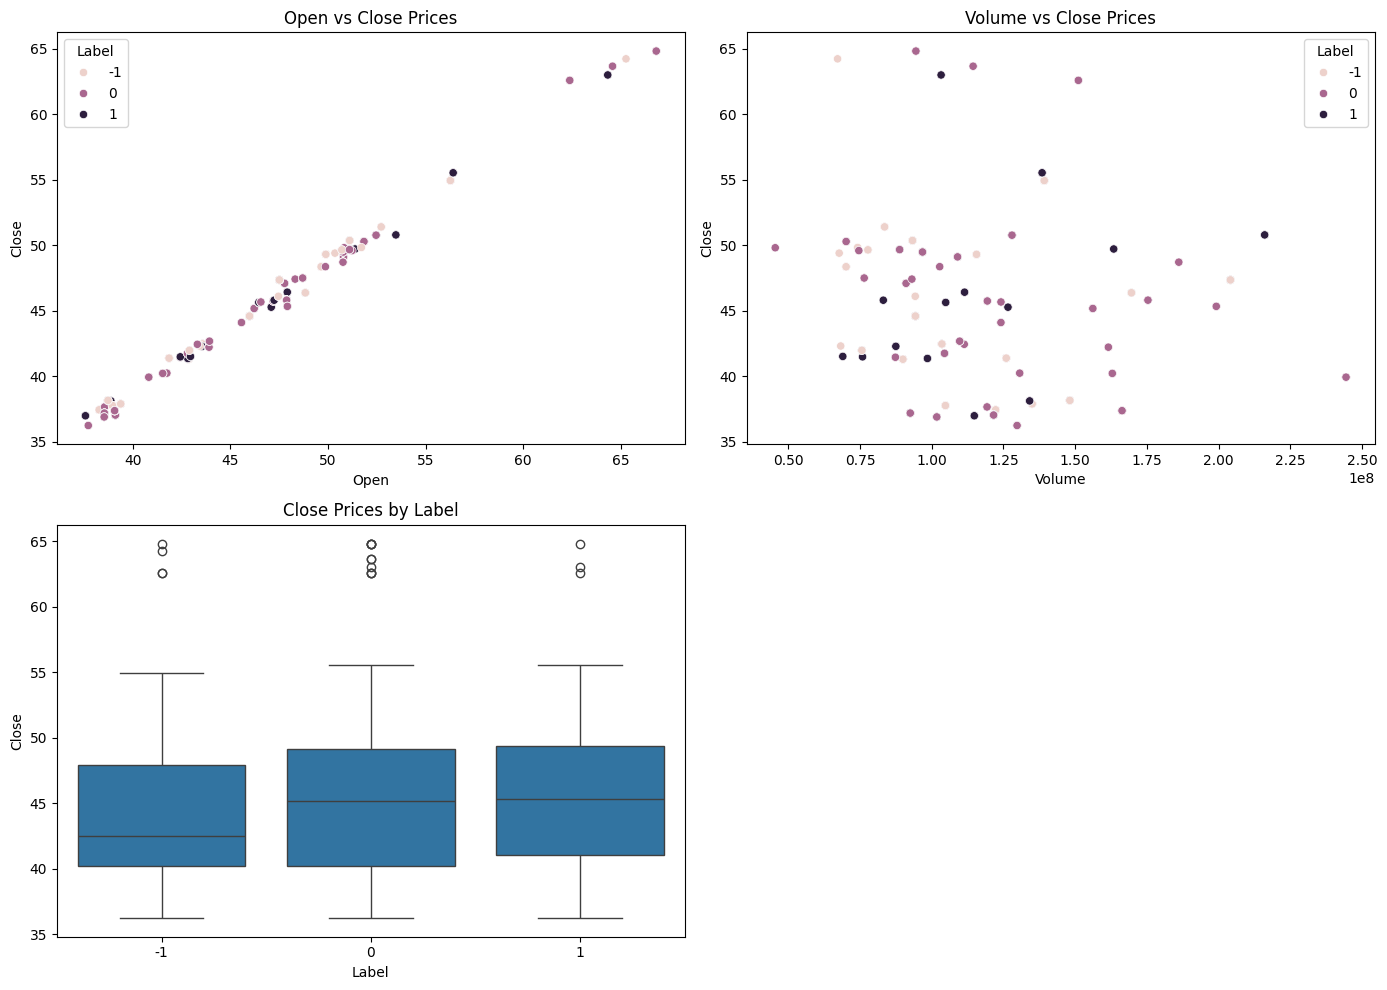

In [9]:
plt.figure(figsize=(14, 10))

# Scatter plot between 'Open' and 'Close' prices
plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='Open', y='Close', hue='Label')
plt.title('Open vs Close Prices')

# Scatter plot between 'Volume' and 'Close' prices
plt.subplot(2, 2, 2)
sns.scatterplot(data=data, x='Volume', y='Close', hue='Label')
plt.title('Volume vs Close Prices')

# Box plot to examine distribution of 'Close' prices by 'Label'
plt.subplot(2, 2, 3)
sns.boxplot(data=data, x='Label', y='Close')
plt.title('Close Prices by Label')

plt.tight_layout()
plt.show()


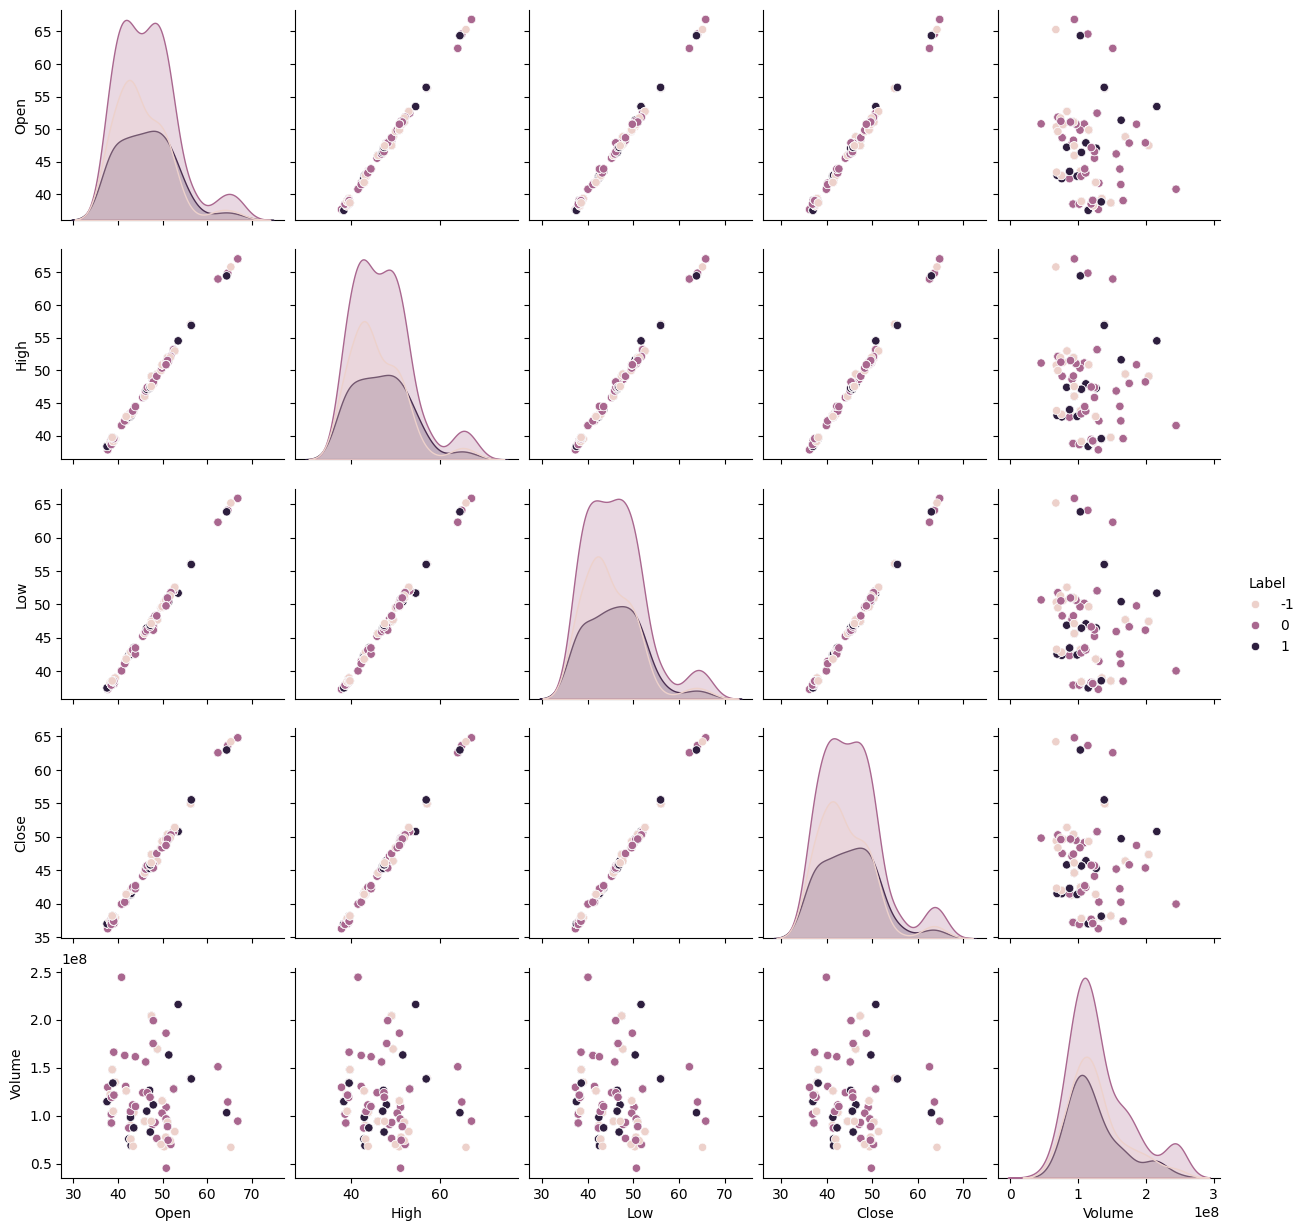

In [11]:
# Pair plot for multiple columns
sns.pairplot(data[['Open', 'High', 'Low', 'Close', 'Volume', 'Label']], hue='Label')
plt.show()

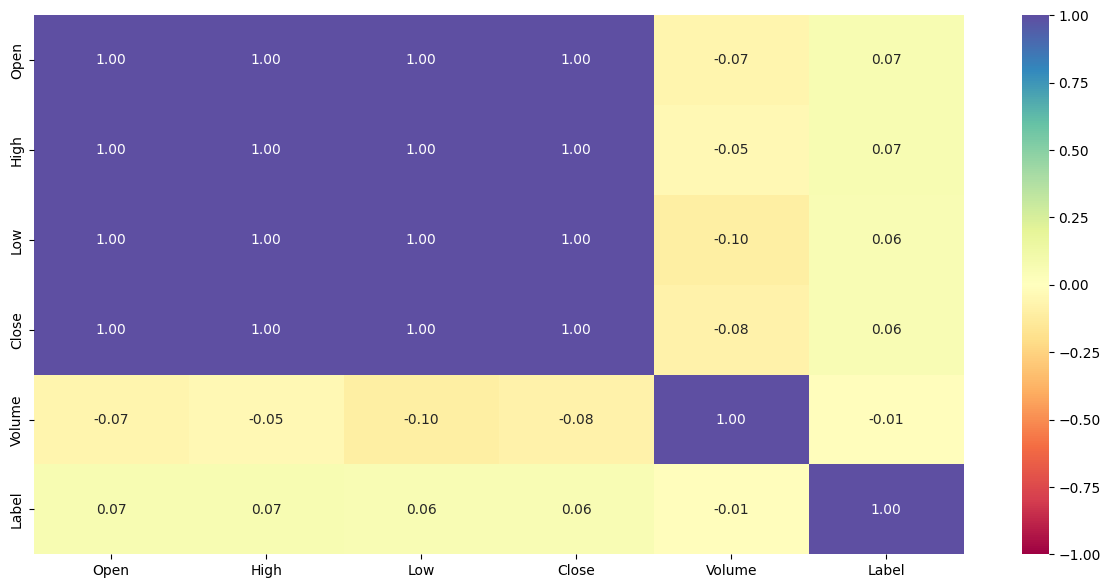

In [ ]:
# Use only numerical features for correlation
numeric_features = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 7))
sns.heatmap(data[numeric_features].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

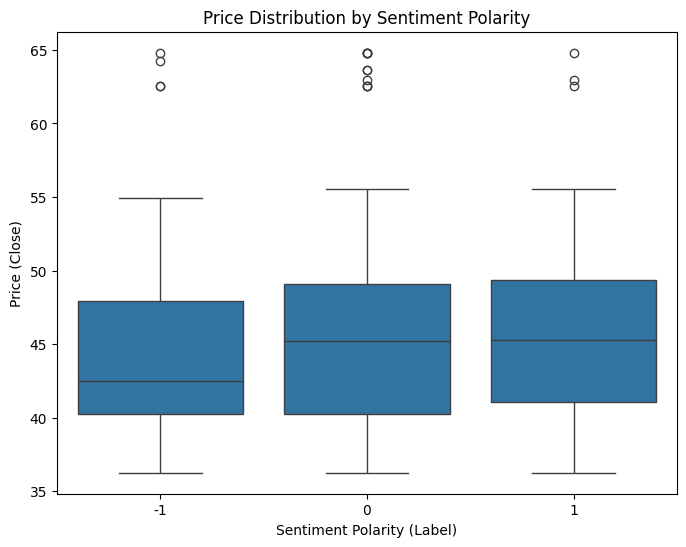

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Close', data=data)
plt.title('Price Distribution by Sentiment Polarity')
plt.xlabel('Sentiment Polarity (Label)')
plt.ylabel('Price (Close)')
plt.show()

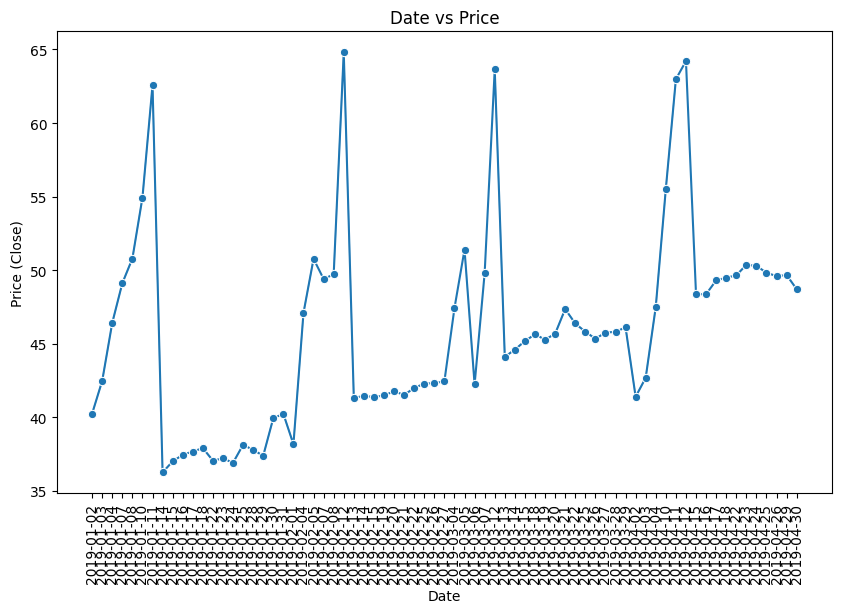

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=data, marker="o")
plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## **Data Preprocessing**

- No missing values
- No duplicates

In [ ]:
# Check for missing values
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
# Check for duplicate values
data.duplicated().sum()

0

## Text Preprocessing

### Removing special characters from the text

In [32]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [33]:
# Applying the function to remove special characters
data['cleaned_text'] = data['News'].apply(remove_special_characters)

In [34]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,The tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,Apple lowered its fiscal Q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,Apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,This news article reports that yields on long...


- We can observe that the function removed the special characters and retained the alphabets and numbers.

### Lowercasing

In [35]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [36]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,this news article reports that yields on long...


- We can observe that all the text has now successfully been converted to lower case.

### Removing extra whitespace

In [37]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

In [38]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on long ...


### Removing stopwords

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.
* The `NLTK` library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [39]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [40]:
# Applying the function to remove stop words using the NLTK library
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

In [41]:
# checking a couple of instances of cleaned data
data.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decl...,tech sector experienced significant decline af...
1,apple lowered its fiscal q1 revenue guidance t...,apple lowered fiscal q1 revenue guidance 84 bi...
2,apple cut its fiscal first quarter revenue for...,apple cut fiscal first quarter revenue forecas...
3,this news article reports that yields on long ...,news article reports yields long dated u treas...


* We observe that all the stopwords have been removed.

### Stemming

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [42]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [43]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [44]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [45]:
# checking a couple of instances of cleaned data
data.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline af...,tech sector experienc signific declin aftermar...
1,apple lowered fiscal q1 revenue guidance 84 bi...,appl lower fiscal q1 revenu guidanc 84 billion...
2,apple cut fiscal first quarter revenue forecas...,appl cut fiscal first quarter revenu forecast ...


## **Word Embeddings**

### BOW Embeddings

In [46]:
# Initializing CountVectorizer with top 1000 words
bow_vec = CountVectorizer(max_features = 1000)

# Applying TfidfVectorizer on data
data_features_BOW = bow_vec.fit_transform(data['final_cleaned_text'])

# Convert the data features to array
data_features_BOW = data_features_BOW.toarray()

# Shape of the feature vector
data_features_BOW.shape

(349, 1000)

In [47]:
# Getting the 1000 words considered by the BoW model
words = bow_vec.get_feature_names_out()

In [48]:
# Creating a DataFrame from the data features
df_BOW = pd.DataFrame(data_features_BOW, columns=bow_vec.get_feature_names_out())
df_BOW.head()

,000,06,10,100,11,13,14,15,16,17,...,xr,year,yen,yet,yield,york,yoy,yuan,zeux,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Glove based embeddings

In [55]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [56]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(model.index_to_key))

Length of the vocabulary is 400000


In [57]:
#List of words in the vocabulary
words = model.index_to_key
#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(model.index_to_key,list(model.vectors)))
#Defining the dimension of the embedded vector.
vec_size=100

In [58]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [59]:
# creating a dataframe of the vectorized documents
df_glove_embeddings = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove_embeddings

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.021671,0.096785,-0.047464,-0.066726,-0.215078,-0.603108,-0.089054,-0.001979,0.114239,-0.132121,...,-0.016118,0.282037,-0.146394,-0.217284,-0.137730,0.162514,0.208869,0.056668,0.186156,-0.025540
1,0.171825,0.341351,0.234650,-0.042054,-0.082840,-0.600302,-0.060674,-0.101788,-0.159387,0.023604,...,0.001762,0.271578,-0.190244,-0.136070,-0.442046,0.225178,0.175980,-0.036701,0.410090,-0.159631
2,0.010512,0.270341,0.301482,-0.087113,0.075485,-0.476547,-0.039534,-0.014161,-0.123561,-0.054536,...,0.113562,0.199301,-0.095302,-0.220799,-0.559601,0.130351,0.039756,-0.088995,0.484577,-0.204774
3,-0.147407,0.226970,0.377158,0.184659,-0.110523,-0.447424,-0.103314,0.033698,-0.021951,-0.041905,...,0.031969,0.314802,-0.276519,0.034750,-0.347012,0.131816,0.201519,-0.220721,0.328415,-0.101222
4,0.040798,0.198312,0.071460,0.037332,-0.098294,-0.407203,-0.078844,-0.102327,-0.132380,-0.031861,...,0.041134,0.188611,-0.051261,-0.364269,-0.216124,0.242409,0.243280,-0.071136,0.173813,-0.131392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.133417,0.058861,0.415255,-0.291097,0.051498,0.079182,0.057609,0.127537,-0.074177,-0.070428,...,0.306373,-0.166262,0.083386,-0.120771,-0.347820,0.049615,-0.054991,-0.299478,0.437251,0.188692
345,0.159967,0.246612,0.288849,0.093632,0.043483,-0.284527,-0.167188,-0.049947,-0.246812,-0.088806,...,0.042174,0.246746,-0.054319,-0.047361,-0.572373,0.368322,0.077437,0.020181,0.441181,0.015956
346,0.043433,0.127144,0.151791,-0.053902,-0.067352,-0.187623,-0.020754,0.138385,-0.354622,-0.084654,...,-0.066027,0.240859,-0.119884,-0.026659,-0.428011,0.054745,-0.025141,-0.129436,0.258558,-0.027775
347,-0.098248,0.090049,0.181622,-0.028409,-0.128997,-0.497643,-0.247336,-0.034014,-0.103773,-0.195073,...,0.012848,0.070933,-0.053851,-0.265540,-0.415342,0.111974,0.295720,-0.207213,0.378713,0.026234


### Transformer based embeddings

In [ ]:
# defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
embedding_matrix = model.encode(data['News'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

In [ ]:
# printing the embedding vector of the first news in the dataset
embedding_matrix[0,:]

array([-2.02308688e-03, -3.67735364e-02,  7.73542598e-02,  4.67134081e-02,
        3.25521305e-02,  2.10231193e-03,  4.32834737e-02,  3.95344906e-02,
        5.82279935e-02,  8.87513440e-03,  7.09636807e-02,  4.99076843e-02,
        6.46608099e-02, -4.97970264e-03, -1.30518479e-02, -2.98355557e-02,
       -8.91322084e-03, -7.82000348e-02, -2.17109658e-02, -5.24822623e-02,
       -5.14276549e-02, -3.30719985e-02, -3.32051516e-02,  4.18125615e-02,
        7.99547583e-02,  1.54092284e-02, -2.15781443e-02,  5.19438535e-02,
       -4.65799086e-02, -3.71372141e-02, -1.04225606e-01,  9.86078903e-02,
        5.21786399e-02,  3.46578993e-02,  1.48809813e-02, -4.47350414e-03,
        5.70117794e-02, -2.41722930e-02,  2.14048829e-02, -6.52144775e-02,
       -3.30645032e-02,  1.61960777e-02, -6.63141608e-02,  4.39943299e-02,
        3.82153168e-02, -4.86519411e-02,  1.62651073e-02, -4.02665772e-02,
       -3.34568229e-03,  3.20955738e-02, -3.91200650e-03, -1.26830470e-02,
        4.49698754e-02,  

## **Sentiment Analysis**

#### Reusable Methods


In [67]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [21]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#### Training Data Split

In [60]:
# Creating dependent and independent variables
X_bow = df_BOW.copy()
X_glove = df_glove_embeddings.copy()
y = data['Label']

In [61]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [62]:
#Splitting the dataset.
X_train_bow,X_valid_bow,X_test_bow,y_train_bow,y_valid_bow,y_test_bow=split(X_bow,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)

In [63]:
print(y_train_bow.shape, y_valid_bow.shape, y_test_bow.shape)

(279,) (35,) (35,)


In [ ]:
print(y_train_glove.shape, y_valid_glove.shape, y_test_glove.shape)

(279,) (35,) (35,)


### RandomForest classification using GloVe Embeddings

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

In [ ]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=0.7,
                       min_samples_split=5, n_estimators=90, random_state=42)

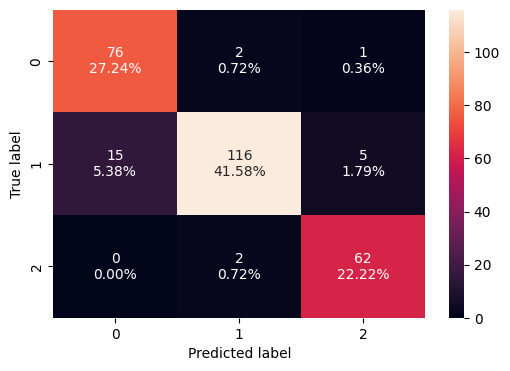

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_train_glove, y_train_glove)

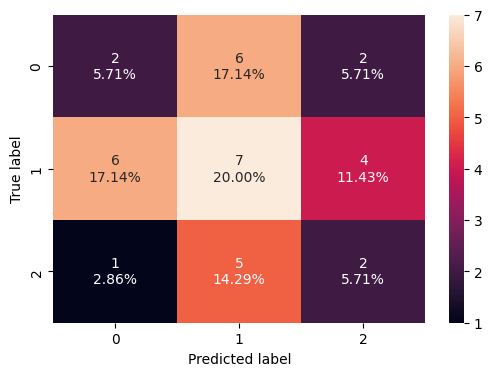

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_valid_glove, y_valid_glove)

In [ ]:
# Predicting on train data
y_pred_train_glove = rf_glove_tuned.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove_tuned.predict(X_valid_glove)

In [ ]:
#Printing
print(classification_report(y_train_glove, y_pred_train_glove))

              precision    recall  f1-score   support

          -1       0.84      0.96      0.89        79
           0       0.97      0.85      0.91       136
           1       0.91      0.97      0.94        64

    accuracy                           0.91       279
   macro avg       0.90      0.93      0.91       279
weighted avg       0.92      0.91      0.91       279



In [ ]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

              precision    recall  f1-score   support

          -1       0.22      0.20      0.21        10
           0       0.39      0.41      0.40        17
           1       0.25      0.25      0.25         8

    accuracy                           0.31        35
   macro avg       0.29      0.29      0.29        35
weighted avg       0.31      0.31      0.31        35



In [ ]:
# Predicting on test data
y_pred_test_glove = rf_glove_tuned.predict(X_test_glove)

In [ ]:
print(classification_report(y_test_glove, y_pred_test_glove))

              precision    recall  f1-score   support

          -1       0.43      0.60      0.50        10
           0       0.64      0.41      0.50        17
           1       0.40      0.50      0.44         8

    accuracy                           0.49        35
   macro avg       0.49      0.50      0.48        35
weighted avg       0.52      0.49      0.49        35



### RandomForest classification using Transformer Embeddings

In [ ]:
X_transf = embedding_matrix
y = data["Label"]

X_train_transf, X_test_transf, y_train_transf, y_test_transf = train_test_split(X_transf, y, test_size=0.25, random_state=42)

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# Building the model
rf_transformer = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_transformer.fit(X_train_transf, y_train_transf)

RandomForestClassifier(max_depth=7, random_state=42)

In [ ]:
# Choose the type of classifier
rf_transformer_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_transformer_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_transf, y_train_transf)

In [ ]:
# Creating a new model with the best combination of parameters
rf_transf_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_transf_tuned.fit(X_train_transf, y_train_transf)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=0.5,
                       min_samples_split=5, n_estimators=90, random_state=42)

In [ ]:
# Predicting on train data
y_pred_train = rf_transf_tuned.predict(X_train_transf)

# Predicting on test data
y_pred_test = rf_transf_tuned.predict(X_test_transf)

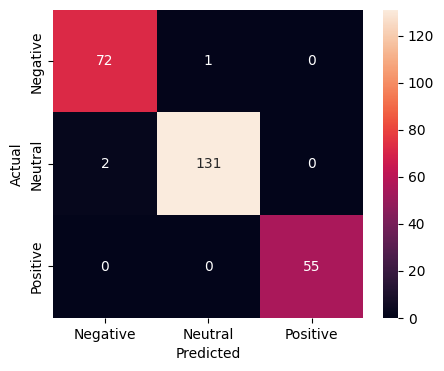

In [ ]:
plot_confusion_matrix(y_train_transf, y_pred_train)

In [ ]:
print(classification_report(y_train_transf, y_pred_train))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98        73
           0       0.99      0.98      0.99       133
           1       1.00      1.00      1.00        55

    accuracy                           0.99       261
   macro avg       0.99      0.99      0.99       261
weighted avg       0.99      0.99      0.99       261



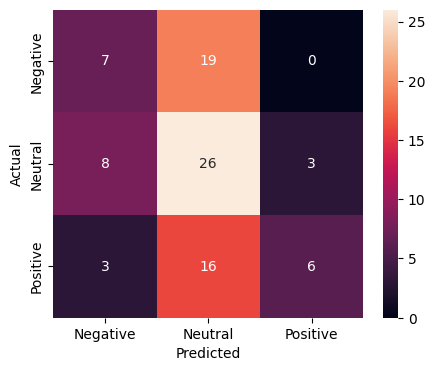

In [ ]:
plot_confusion_matrix(y_test_transf, y_pred_test)

In [ ]:
print(classification_report(y_test_transf, y_pred_test))

              precision    recall  f1-score   support

          -1       0.39      0.27      0.32        26
           0       0.43      0.70      0.53        37
           1       0.67      0.24      0.35        25

    accuracy                           0.44        88
   macro avg       0.49      0.40      0.40        88
weighted avg       0.48      0.44      0.42        88



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.56      0.19      0.29        26
           0       0.45      0.92      0.61        37
           1       0.75      0.12      0.21        25

    accuracy                           0.48        88
   macro avg       0.59      0.41      0.37        88
weighted avg       0.57      0.48      0.40        88



### DistilBERT Pretrained Sentiment Analysis

In [26]:
data_bert = data.copy()
data_bert['Label'] = data_bert['Label'].replace({
    -1: 'NEGATIVE',
    0: 'NEUTRAL',
    1: 'POSITIVE'
})
y = data_bert["Label"]

In [ ]:
sentiment_hf = pipeline("sentiment-analysis") # this uses the HF default sentiment analysis model

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
trial_data = ["Love it! The Product is fantastic—sleek design, top-notch quality, and it exceeded my expectations. Highly recommended!"]
sentiment_hf(trial_data)

[{'label': 'POSITIVE', 'score': 0.999884843826294}]

In [18]:
hf_review_dict = sentiment_hf(data['News'].to_list(),truncation=True)

In [19]:
hf_review_sent = [0]*len(data['News'])

for product in range(len(data['News'])):
    if hf_review_dict[product]['label'] == 'POSITIVE':
        hf_review_sent[product] = 'POSITIVE'
    elif hf_review_dict[product]['label'] == 'NEUTRAL':
        hf_review_sent[product] = 'NEUTRAL'
    else:
        hf_review_sent[product] = 'NEGATIVE'

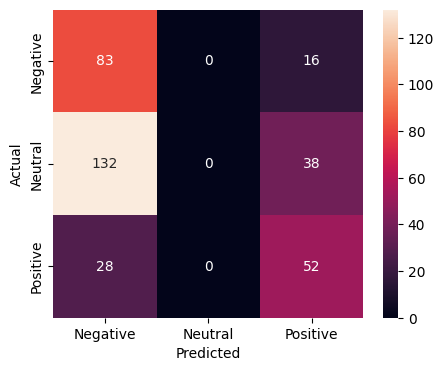

In [27]:
plot_confusion_matrix(y, hf_review_sent)

In [28]:
print(classification_report(y, hf_review_sent))

              precision    recall  f1-score   support

    NEGATIVE       0.34      0.84      0.49        99
     NEUTRAL       0.00      0.00      0.00       170
    POSITIVE       0.49      0.65      0.56        80

    accuracy                           0.39       349
   macro avg       0.28      0.50      0.35       349
weighted avg       0.21      0.39      0.27       349



### RandomForest classification using BOW Encodings

In [86]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_bow, y_train_bow)

In [77]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_resampled, y_resampled)

In [78]:
# Creating a new model with the best combination of parameters
rf_bow_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_bow_tuned.fit(X_train_bow, y_train_bow)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=5, n_estimators=80, random_state=42)

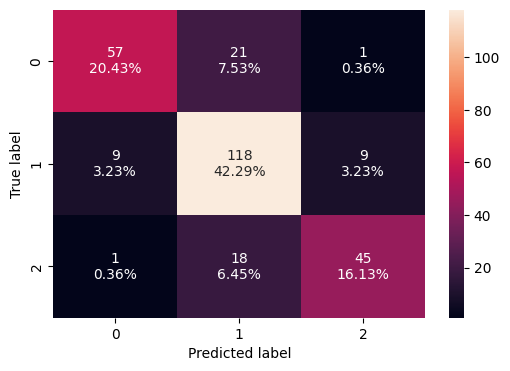

In [68]:
confusion_matrix_sklearn(rf_bow_tuned, X_train_bow, y_train_bow)

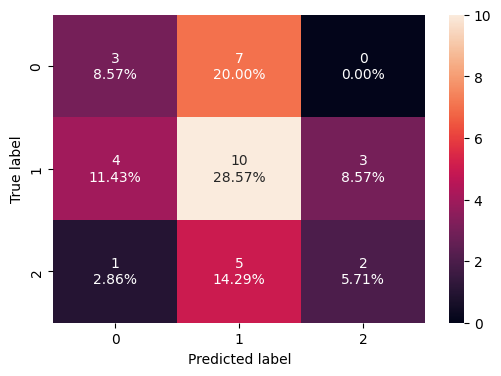

In [69]:
confusion_matrix_sklearn(rf_bow_tuned, X_valid_bow, y_valid_bow)

In [79]:
# Predicting on train data
y_pred_train_bow = rf_bow_tuned.predict(X_train_bow)

# Predicting on validation data
y_pred_valid_bow = rf_bow_tuned.predict(X_valid_bow)

In [80]:
print(classification_report(y_train_bow, y_pred_train_bow))

              precision    recall  f1-score   support

          -1       0.76      0.73      0.75        79
           0       0.81      0.83      0.82       136
           1       0.86      0.86      0.86        64

    accuracy                           0.81       279
   macro avg       0.81      0.81      0.81       279
weighted avg       0.81      0.81      0.81       279



In [81]:
print(classification_report(y_valid_bow, y_pred_valid_bow))

              precision    recall  f1-score   support

          -1       0.33      0.30      0.32        10
           0       0.45      0.59      0.51        17
           1       0.75      0.38      0.50         8

    accuracy                           0.46        35
   macro avg       0.51      0.42      0.44        35
weighted avg       0.49      0.46      0.45        35



In [82]:
# Predicting on test data
y_pred_test_bow = rf_bow_tuned.predict(X_test_bow)

print(classification_report(y_test_bow, y_pred_test_bow))

              precision    recall  f1-score   support

          -1       0.43      0.60      0.50        10
           0       0.50      0.35      0.41        17
           1       0.22      0.25      0.24         8

    accuracy                           0.40        35
   macro avg       0.38      0.40      0.38        35
weighted avg       0.42      0.40      0.40        35



## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [1]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00


In [2]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [3]:
stock_news = pd.read_csv("/content/stock_news.csv")

In [4]:
# creating a copy of the dataset
data = stock_news.copy()

#### Loading the model

##### LLAMA 13B Model (Not used as memory not enough)

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    #n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=6000,  # Context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

##### Mistral 7B Model

In [5]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [6]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [7]:
llm = Llama(
    model_path=model_path,
    n_ctx=17000,
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [8]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [9]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [10]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [11]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [12]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [13]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [14]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [15]:
# defining the instructions for the model
instruction_1 = """
    Role: You are an AI analyzing news content. News article are grouped by week. Classify the overall sentiment to postive and negative.

    Task: Summarize the news from the week by identifying the top 3 positive and negative events that are most likely to impact the price of the stock.

    Provide the output in a JSON format ensuring consistency, no special characters or line escapes and handling missing values appropriately.
    Ensure that all values in the JSON are formatted as strings.
    {"Positive":"summarized_top_3_news_with_postive_prediction","Negative":"summarized_top_3_news_with_negative_prediction"}

    Instructions:
    - Json output should be in the above format.
    - Json output should have only 2 keys, one key positive and another key negative.
    - Json output should not be an array and should have multiple values.
    - Donot include special character like quotes in the postive negative summary.
    - Donot include any new line characters.
    - Summarize only top 3 positive and negative news in a concise manner.
    - Only return the JSON, do not return any other information and remove the extra spaces.
"""

In [16]:
len(data_1['News'][15])

6576

In [17]:
data_1['News'][15]

" The chairman of Taiwan's Foxconn, Terry Gou, plans to step down from his position in the coming months to allow younger talent to take over. This comes as Foxconn tries to diversify its business and reduce its reliance on Apple, which is also seeking new suppliers. Gou hopes to remain involved in strategic decisions but not daily ||  Amazon's potential entry into the free music streaming market sent shockwaves through the industry, with shares of Amazon NASDAQ AMZN and Spotify NYSE:SPOT sliding in early trading. According to a report by Billboard, Amazon has entered into discussions to launch a free, ad-supported music service, which could become available ||  In a complex trial in San Diego, Apple accused Qualcomm of abusing market power by using its patent licensing practices to maintain control over premium modem chips for smartphones. Qualcomm countered that Apple bullied contract manufacturers into withholding royalty payments, amounting to billions in potential revenue loss. Th

In [18]:
max_length = data_1['News'].str.len().max()
print('Maximum length of News column in entire grouped dataset : ', max_length)

Maximum length of News column in entire grouped dataset :  16090


In [21]:
test_response = response_mistral_1(instruction_1, data_1['News'][15])

Llama.generate: 1738 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   28941.78 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    95 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   10751.82 ms /    96 tokens


In [22]:
extract_json_data(test_response)

{'Positive': 'Foxconn chairman Terry Gou announces intention to contest Taiwan presidential election, TomTom reports 14% increase in first quarter revenue, Aeva signs deal with Audi for lidar sensor systems',
 'Negative': 'Apple faces securities fraud lawsuit for allegedly concealing weakened iPhone demand, Qualcomm accused of abusing market power, TikTok removed from Indian app stores for inappropriate content'}

##### Checking the model output on the weekly data

In [23]:
data_1['llm_response'] = data_1['News'].apply(lambda x: response_mistral_1(instruction_1, x))

Llama.generate: 294 prefix-match hit, remaining 3744 prompt tokens to eval
llama_perf_context_print:        load time =   28941.78 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3744 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /  1023 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  193990.63 ms /  4767 tokens
Llama.generate: 293 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =   28941.78 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   211 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   58367.10 ms /  2445 tokens
Llama.generate: 293 prefix-match hit, remaining 2089 prompt tokens to eval
llama

In [35]:
#Sample 15th row
data_1.loc[15]

,15
Date,2019-04-21 00:00:00
News,"The chairman of Taiwan's Foxconn, Terry Gou, ..."
llm_response,"{""Positive"": ""Foxconn chairman Terry Gou annou..."


In [49]:
data_1['News'].loc[15]

" The chairman of Taiwan's Foxconn, Terry Gou, plans to step down from his position in the coming months to allow younger talent to take over. This comes as Foxconn tries to diversify its business and reduce its reliance on Apple, which is also seeking new suppliers. Gou hopes to remain involved in strategic decisions but not daily ||  Amazon's potential entry into the free music streaming market sent shockwaves through the industry, with shares of Amazon NASDAQ AMZN and Spotify NYSE:SPOT sliding in early trading. According to a report by Billboard, Amazon has entered into discussions to launch a free, ad-supported music service, which could become available ||  In a complex trial in San Diego, Apple accused Qualcomm of abusing market power by using its patent licensing practices to maintain control over premium modem chips for smartphones. Qualcomm countered that Apple bullied contract manufacturers into withholding royalty payments, amounting to billions in potential revenue loss. Th

In [39]:
data_1['llm_response'].loc[15]

'{"Positive": "Foxconn chairman Terry Gou announces intention to contest Taiwan presidential election, TomTom reports 14% increase in first quarter revenue, Aeva signs deal with Audi for lidar sensor systems",\n        "Negative": "Apple faces securities fraud lawsuit for allegedly concealing weakened iPhone demand, Qualcomm accused of abusing market power, TikTok removed from Google and Apple app stores in India"}'

In [50]:
#Sample 15th row
data_1.loc[6]

,6
Date,2019-02-17 00:00:00
News,"This week, the European Union's second highes..."
llm_response,"{""Positive"": ""Apple's stronger than projected ..."


In [51]:
data_1['News'].loc[6]

" This week, the European Union's second highest court will rule on a Belgian tax break that reportedly benefited over 35 large companies, including Apple, Starbucks, Fiat Chrysler, and others. The European Commission ordered Belgium to recover around €790 million from these firms for allegedly providing an unfair advantage ||  Akamai Technologies reported stronger than projected earnings, driven by increased demand for its cybersecurity and media content delivery services. Revenue from its cloud security business rose 36% to $185 million, and the security unit is expected to exceed $1 billion in annual revenue soon. The company's media and carrier division saw an ||  Apple is facing resistance from several publications over its proposed news subscription service, which could be priced around $10 per month. The company plans to keep about half of the revenue but has not yet finalized the price. Apple's transaction fee of 30 percent for software developers in the App Store may be a conc

In [52]:
data_1['llm_response'].loc[6]

'{"Positive": "Apple\'s stronger than projected earnings, revenue from cloud security business rose 36% to $185 million, Akamai Technologies\' media and carrier division saw an increase, NVIDIA forecasted better-than-expected sales, Apple targeting April event for streaming television service, Apple significantly increased self-driving car tests in 2018, Warren Buffett\'s Berkshire Hathaway added positions in Suncor Energy and software firm Red Hat",\n      "Negative": "European Union\'s second highest court to rule on Belgian tax break that allegedly benefited large companies including Apple, Goldman analyst anticipates Apple\'s traffic acquisition costs from Google searches will decelerate significantly, U.K. government recommends greater regulation of tech companies, Japan Display Inc reportedly set to receive funding from Chinese and Taiwanese investors, Trump administration forms new advisory board with major company CEOs, Apple facing resistance from publications over proposed ne

In [42]:
data_1.tail()

,Date,News,llm_response
13,2019-04-07,"Apple and other consumer brands, including LV...","{""Positive"": ""Apple and other brands reduce pr..."
14,2019-04-14,"In March, mobile phone shipments to China dro...","{""Positive"": ""Apple documentary by Oprah Winfr..."
15,2019-04-21,"The chairman of Taiwan's Foxconn, Terry Gou, ...","{""Positive"": ""Foxconn chairman Terry Gou annou..."
16,2019-04-28,Taiwan's export orders continued to decline f...,"{""Positive"": ""Tencent Holdings invests in Arge..."
17,2019-05-05,Spotify reported better-than-expected Q1 reve...,"{""Positive"": ""Spotify exceeded revenue expecta..."


In [43]:
data_1.shape

(18, 3)

##### Formatting the model output

In [44]:
data_1_formatted = data_1.copy()
data_1_formatted["llm_response_dict"] = data_1_formatted["llm_response"].apply(extract_json_data)

        "Negative": "Apple cut quarterly revenue forecast, triggering global market declines and supplier losses, yields on long-dated U.S. Treasury securities hit lowest levels in nearly a year due to global economic concerns, Apple's revenue warning led to significant drop in Apple's stock price and Asian suppliers, Apple's underperformance in Q1 attributed to lower iPhone revenue and upgrades, weak demand in China and trade tensions, several brokerages reduced production estimates, Australian dollar experienced significant volatility and plunged to multi-year lows, Japanese yen surged as US dollar and Australian dollar collapsed, long-term US Treasury yields dropped significantly below 2.6%, gold prices reached highest level since mid-June due to investor concerns over a slowing economy and Apple's bearish revenue outlook, oil prices dropped on Thursday due to China's economic slowdown and turmoil in stock and currency markets, investors withdrew record $98 billion from U.S. stock f

In [46]:
data_1_formatted.tail()

,Date,News,llm_response,llm_response_dict
13,2019-04-07,"Apple and other consumer brands, including LV...","{""Positive"": ""Apple and other brands reduce pr...",{'Positive': 'Apple and other brands reduce pr...
14,2019-04-14,"In March, mobile phone shipments to China dro...","{""Positive"": ""Apple documentary by Oprah Winfr...",{'Positive': 'Apple documentary by Oprah Winfr...
15,2019-04-21,"The chairman of Taiwan's Foxconn, Terry Gou, ...","{""Positive"": ""Foxconn chairman Terry Gou annou...",{'Positive': 'Foxconn chairman Terry Gou annou...
16,2019-04-28,Taiwan's export orders continued to decline f...,"{""Positive"": ""Tencent Holdings invests in Arge...",{'Positive': 'Tencent Holdings invests in Arge...
17,2019-05-05,Spotify reported better-than-expected Q1 reve...,"{""Positive"": ""Spotify exceeded revenue expecta...",{'Positive': 'Spotify exceeded revenue expecta...


In [56]:
# formatting dictionary column into 2 columns
data_1_formatted2 = data_1_formatted.join(pd.json_normalize(data_1_formatted['llm_response_dict']))
data_1_formatted2.drop(columns=['llm_response', 'llm_response_dict'], inplace=True)

In [57]:
data_1_formatted2.tail()

,Date,News,Positive,Negative
13,2019-04-07,"Apple and other consumer brands, including LV...",Apple and other brands reduce prices in China ...,Apple's NASDAQ stock decreases due to price cu...
14,2019-04-14,"In March, mobile phone shipments to China dro...",Apple documentary by Oprah Winfrey and Prince ...,Mobile phone shipments to China drop by 6% for...
15,2019-04-21,"The chairman of Taiwan's Foxconn, Terry Gou, ...",Foxconn chairman Terry Gou announces intention...,Apple faces securities fraud lawsuit for alleg...
16,2019-04-28,Taiwan's export orders continued to decline f...,Tencent Holdings invests in Argentine mobile b...,Taiwan's export orders decline for fifth conse...
17,2019-05-05,Spotify reported better-than-expected Q1 reve...,Spotify exceeded revenue expectations with 100...,Czech Finance Ministry plans to impose a 7% di...


In [58]:
data_1_formatted2.loc[10]

,10
Date,2019-03-17 00:00:00
News,The United States opposes France's digital se...
Positive,Apple launches new television advertising camp...
Negative,The United States opposes France's digital ser...


In [59]:
data_1_formatted2['Positive'].loc[10]

'Apple launches new television advertising campaign emphasizing data privacy, S&P 500 and Nasdaq post best weekly gains since November, Apple responds to EU antitrust regulators allegations, S&P 500 Technology Index and Philadelphia Semiconductor Index surge'

In [60]:
data_1_formatted2['Negative'].loc[10]

"The United States opposes France's digital services tax, Boeing's NYSE BA stock experiences significant losses, Smartphone shipments to China drop to lowest level in six years, Spotify files complaint against Apple, European Commission delays decision on UK tax scheme, EU considering opening investigation into Apple, General Electric expects lower earnings, Facebook faces data deals investigation, Oracle warns of potential revenue drop"

## **Conclusions and Recommendations**

Conclusions
- `Randomforest model using GloVe embeddings` with more historical data can perform better to predict the sentiment of the stock news, so we need to collect more data and label them.
- Summarization can be done with less parameter models like `Mistral 7B` as long as the prompt is engineered to the right way.
- Using AI and ML to derive the stock sentiment analysis will definitely upsell the product offerings as it can reduce the media bias.

Recommendations
- News summarization on a weekly basis to customers would educate them on the stocks they follow.
- Providing an upfront sentiment on a particular stock ticker would allow the customers to trust the system.
- Financial analysts would get more insights in reshuffling the portfolios based on the sentiment analysis notifications.
